In [ ]:
# Core Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tqdm import tqdm
from tqdm.notebook import tqdm

#Misspelling algorithm
import csv
from collections import defaultdict
import Levenshtein
import os


# 1. Network Source

**Primary source**: Marvel characters and comics [dataset](https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network)

**Data components**: 
- `nodes.csv`: Contains node identifiers and types (hero or comic)
- `edges.csv`: Contains hero-comic relationships (which heroes appear in which comics)
- `hero-edge.csv`: Contains the network of heroes that appear together

# 2. Data Loading

In [23]:
# Load the datasets
nodes_df = pd.read_csv('Data/nodes.csv')
edges_df = pd.read_csv('Data/edges.csv')
hero_network_df = pd.read_csv('Data/hero-network.csv')

# Display the first few rows of each dataset
print("Nodes DataFrame:")
display(nodes_df.head())
print("\nEdges DataFrame:")
display(edges_df.head())
print("\nHero Network DataFrame:")
display(hero_network_df.head())

Nodes DataFrame:


,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero



Edges DataFrame:


,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251



Hero Network DataFrame:


,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


# 3. Data Quality and Preprocessing

## 3.1. Nodes information

Number of nodes: 19090
Number of hero-comic connections: 96104
Number of hero-hero connections: 574467

Node type distribution:
type
comic    12651
hero      6439
Name: count, dtype: int64


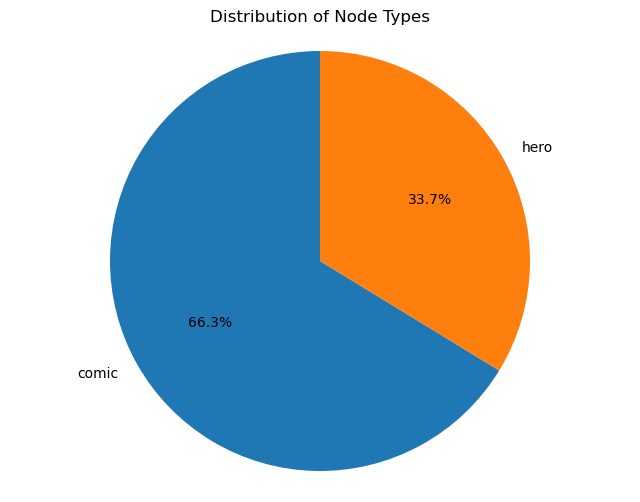

In [24]:
print(f"Number of nodes: {len(nodes_df)}")
print(f"Number of hero-comic connections: {len(edges_df)}")
print(f"Number of hero-hero connections: {len(hero_network_df)}")

# Count the node types
node_type_counts = nodes_df['type'].value_counts()
print("\nNode type distribution:")
print(node_type_counts)

# Create a pie chart for node types
plt.figure(figsize=(8, 6))
plt.pie(node_type_counts, labels=node_type_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Node Types')
plt.axis('equal')
plt.show()

## 3.2. Quality check 

### 3.2.1 Misspelling mistakes

In [33]:
#!/usr/bin/env python3
"""
Hero Name Spelling Consistency Checker (Jupyter Notebook Version)

This script analyzes three CSV files (edges.csv, heronetwork.csv, and nodes.csv)
to identify potential spelling inconsistencies in hero names across the files.
"""

import csv
from collections import defaultdict
import pandas as pd
import Levenshtein  # pip install python-Levenshtein

# Set your file paths here
EDGES_FILE = 'Data/edges.csv'  # MODIFY THIS PATH
HERONETWORK_FILE = 'Data/hero-network.csv'  # MODIFY THIS PATH
NODES_FILE = 'Data/nodes.csv'  # MODIFY THIS PATH

# Configuration
SIMILARITY_THRESHOLD = 0.8  # Minimum similarity to consider (0-1)
MIN_NAME_LENGTH = 4  # Minimum name length to compare
OUTPUT_FILE = 'hero_spelling_results.csv'  # Output file name
RESULT_LIMIT = None  # Limit number of results (None for all)


def load_hero_names(edges_file, heronetwork_file, nodes_file):
    """
    Load hero names from all three CSV files and track their sources.
    
    Returns:
        dict: A dictionary with hero names as keys and a dict of sources as values
    """
    hero_sources = defaultdict(lambda: {'edges': False, 'heronetwork': False, 'nodes': False})
    
    # Load from edges.csv
    try:
        edges_df = pd.read_csv(edges_file)
        for hero in edges_df['hero'].unique():
            hero_sources[hero]['edges'] = True
        print(f"Loaded {len(edges_df['hero'].unique())} unique heroes from edges.csv")
    except Exception as e:
        print(f"Error loading edges.csv: {e}")
    
    # Load from heronetwork.csv
    try:
        heronet_df = pd.read_csv(heronetwork_file)
        for hero in heronet_df['hero1'].unique():
            hero_sources[hero]['heronetwork'] = True
        for hero in heronet_df['hero2'].unique():
            hero_sources[hero]['heronetwork'] = True
        print(f"Loaded {len(set(heronet_df['hero1']).union(set(heronet_df['hero2'])))} unique heroes from heronetwork.csv")
    except Exception as e:
        print(f"Error loading heronetwork.csv: {e}")
    
    # Load from nodes.csv
    try:
        nodes_df = pd.read_csv(nodes_file)
        hero_nodes = nodes_df[nodes_df['type'] == 'hero']
        for hero in hero_nodes['node'].unique():
            hero_sources[hero]['nodes'] = True
        print(f"Loaded {len(hero_nodes['node'].unique())} unique heroes from nodes.csv")
    except Exception as e:
        print(f"Error loading nodes.csv: {e}")
    
    print(f"Total unique hero names across all files: {len(hero_sources)}")
    return hero_sources


def calculate_similarity(str1, str2):
    """
    Calculate string similarity based on Levenshtein distance.
    
    Returns:
        float: Similarity score between 0 and 1
    """
    distance = Levenshtein.distance(str1.lower(), str2.lower())
    max_len = max(len(str1), len(str2))
    return 1 - (distance / max_len) if max_len > 0 else 1


def find_similar_names(hero_sources, threshold=0.8, min_length=4):
    """
    Find hero names that are similar but not identical.
    
    Args:
        hero_sources: Dictionary of hero names and their sources
        threshold: Minimum similarity score to consider (default: 0.8)
        min_length: Minimum length of names to compare (default: 4)
        
    Returns:
        list: List of dictionaries with similar name pairs and their info
    """
    similar_pairs = []
    processed_pairs = set()
    heroes = list(hero_sources.keys())
    
    # Sort heroes by length for optimization
    heroes.sort(key=len)
    
    print(f"Finding similar names (threshold: {threshold}, min length: {min_length})...")
    total = len(heroes)
    
    for i, hero1 in enumerate(heroes):
        if len(hero1) < min_length:
            continue
            
        if i % 100 == 0:
            print(f"Progress: {i}/{total} heroes processed...")
            
        for hero2 in heroes[i+1:]:
            # Skip if second hero is much longer (optimization)
            if len(hero2) > len(hero1) * 1.5:
                break
                
            # Skip very short names
            if len(hero2) < min_length:
                continue
                
            # Check if we've processed this pair
            pair_key = '|'.join(sorted([hero1, hero2]))
            if pair_key in processed_pairs:
                continue
            processed_pairs.add(pair_key)
            
            # Calculate similarity
            similarity = calculate_similarity(hero1, hero2)
            
            # If similarity is above threshold and names are not identical
            if similarity >= threshold and similarity < 1:
                similar_pairs.append({
                    'hero1': hero1,
                    'hero2': hero2,
                    'similarity': similarity,
                    'sources1': hero_sources[hero1],
                    'sources2': hero_sources[hero2]
                })
    
    # Sort by similarity (highest first)
    similar_pairs.sort(key=lambda x: x['similarity'], reverse=True)
    return similar_pairs


def format_source_info(sources):
    """Format source information for display"""
    source_list = []
    if sources['edges']:
        source_list.append('edges.csv')
    if sources['heronetwork']:
        source_list.append('heronetwork.csv')
    if sources['nodes']:
        source_list.append('nodes.csv')
    return ', '.join(source_list)


def export_results(similar_pairs, output_file):
    """Export results to a CSV file"""
    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Hero Name 1', 'Hero Name 2', 'Similarity (%)', 'Sources for Hero 1', 'Sources for Hero 2'])
        
        for pair in similar_pairs:
            writer.writerow([
                pair['hero1'], 
                pair['hero2'],
                f"{pair['similarity'] * 100:.1f}",
                format_source_info(pair['sources1']),
                format_source_info(pair['sources2'])
            ])
    
    print(f"Results exported to {output_file}")


# Run the script (this will execute when you run the cell)
def run_analysis():
    print("Loading hero names from CSV files...")
    hero_sources = load_hero_names(EDGES_FILE, HERONETWORK_FILE, NODES_FILE)
    
    similar_pairs = find_similar_names(
        hero_sources, 
        threshold=SIMILARITY_THRESHOLD,
        min_length=MIN_NAME_LENGTH
    )
    
    if RESULT_LIMIT:
        similar_pairs = similar_pairs[:RESULT_LIMIT]
    
    print(f"Found {len(similar_pairs)} potential spelling inconsistencies")
    
    # Print top 10 results
    print("\nTop potential inconsistencies:")
    for i, pair in enumerate(similar_pairs[:10]):
        print(f"{i+1}. {pair['hero1']} <-> {pair['hero2']} ({pair['similarity']:.3f})")
        print(f"   Sources for {pair['hero1']}: {format_source_info(pair['sources1'])}")
        print(f"   Sources for {pair['hero2']}: {format_source_info(pair['sources2'])}")
        print()
    
    export_results(similar_pairs, OUTPUT_FILE)
    return similar_pairs

# Execute the analysis
similar_pairs = run_analysis()

# You can also analyze the results further in the notebook
# For example:
# import pandas as pd
results_df = pd.DataFrame(similar_pairs)
results_df.head()

Loading hero names from CSV files...
Loaded 6439 unique heroes from edges.csv
Loaded 6426 unique heroes from heronetwork.csv
Loaded 6439 unique heroes from nodes.csv
Total unique hero names across all files: 6584
Finding similar names (threshold: 0.8, min length: 4)...
Progress: 100/6584 heroes processed...
Progress: 200/6584 heroes processed...
Progress: 300/6584 heroes processed...
Progress: 400/6584 heroes processed...
Progress: 500/6584 heroes processed...
Progress: 600/6584 heroes processed...
Progress: 700/6584 heroes processed...
Progress: 800/6584 heroes processed...
Progress: 900/6584 heroes processed...
Progress: 1000/6584 heroes processed...
Progress: 1100/6584 heroes processed...
Progress: 1200/6584 heroes processed...
Progress: 1300/6584 heroes processed...
Progress: 1400/6584 heroes processed...
Progress: 1500/6584 heroes processed...
Progress: 1600/6584 heroes processed...
Progress: 1700/6584 heroes processed...
Progress: 1800/6584 heroes processed...
Progress: 1900/6584

,hero1,hero2,similarity,sources1,sources2
0,AGAMEMNON II/ANDREI,AGAMEMNON II/ANDREI,0.95,"{'edges': True, 'heronetwork': False, 'nodes':...","{'edges': False, 'heronetwork': True, 'nodes':..."
1,ANDROMEDA/ANDROMEDA,ANDROMEDA/ANDROMEDA,0.95,"{'edges': True, 'heronetwork': False, 'nodes':...","{'edges': False, 'heronetwork': True, 'nodes':..."
2,"ANGELOPOULOS, ANGEL","ANGELOPOULOS, ANGEL",0.95,"{'edges': True, 'heronetwork': False, 'nodes':...","{'edges': False, 'heronetwork': True, 'nodes':..."
3,APE MAN/GORDON MONK,APE MAN/GORDON MONK,0.95,"{'edges': True, 'heronetwork': False, 'nodes':...","{'edges': False, 'heronetwork': True, 'nodes':..."
4,APOCALYPSE/EN SABAH,APOCALYPSE/EN SABAH,0.95,"{'edges': True, 'heronetwork': False, 'nodes':...","{'edges': False, 'heronetwork': True, 'nodes':..."


After a torough manual inspection of the outputed `hero_spelling_results.csv`, we have corrected the spelling mistakes in our datasets and renamed the corrected files as: 
- `edges_corr.csv`
- `hero_network_corr.csv`
- `nodes_corr.csv`

We will from now on use the corrected data.

In [34]:
# Remove the space after at the end of the name
#!/usr/bin/env python3
"""
Remove trailing spaces from hero names in the hero-network_corr.csv file.

This script reads the hero-network_corr.csv file, removes any trailing spaces
from hero names in both columns, and writes the result to a new file.
"""

import pandas as pd
import os

# Input and output file paths
INPUT_FILE = 'Data/hero-network_corr.csv'
OUTPUT_FILE = 'Data/hero-network_corr_cleaned.csv'

def clean_trailing_spaces():
    print(f"Reading file: {INPUT_FILE}")
    
    try:
        # Read the CSV file
        df = pd.read_csv(INPUT_FILE)
        
        # Show original column names and first few rows
        print("\nOriginal data sample:")
        print(df.head())
        
        # Get total row count
        original_rows = len(df)
        print(f"\nTotal rows in original file: {original_rows}")
        
        # Identify column names (they might vary)
        columns = df.columns.tolist()
        if len(columns) != 2:
            print(f"Warning: Expected 2 columns, found {len(columns)}: {columns}")
        
        hero1_col = columns[0]  # Typically 'hero1'
        hero2_col = columns[1]  # Typically 'hero2'
        
        # Check for trailing spaces before cleaning
        hero1_trailing_spaces = df[df[hero1_col].str.endswith(' ', na=False)].shape[0]
        hero2_trailing_spaces = df[df[hero2_col].str.endswith(' ', na=False)].shape[0]
        
        print(f"\nBefore cleaning:")
        print(f"- Names with trailing spaces in {hero1_col}: {hero1_trailing_spaces}")
        print(f"- Names with trailing spaces in {hero2_col}: {hero2_trailing_spaces}")
        
        # Sample of entries with trailing spaces (for verification)
        if hero1_trailing_spaces > 0:
            print("\nSample entries with trailing spaces in first column:")
            trailing_samples = df[df[hero1_col].str.endswith(' ', na=False)].head(5)
            for _, row in trailing_samples.iterrows():
                print(f"'{row[hero1_col]}' -> '{row[hero1_col].rstrip()}'")
                
        # Apply the string strip function to remove trailing spaces
        df[hero1_col] = df[hero1_col].str.rstrip()
        df[hero2_col] = df[hero2_col].str.rstrip()
        
        # Verify cleaning worked
        hero1_trailing_spaces_after = df[df[hero1_col].str.endswith(' ', na=False)].shape[0]
        hero2_trailing_spaces_after = df[df[hero2_col].str.endswith(' ', na=False)].shape[0]
        
        print(f"\nAfter cleaning:")
        print(f"- Names with trailing spaces in {hero1_col}: {hero1_trailing_spaces_after}")
        print(f"- Names with trailing spaces in {hero2_col}: {hero2_trailing_spaces_after}")
        
        # Write the cleaned data to a new CSV file
        df.to_csv(OUTPUT_FILE, index=False)
        print(f"\nCleaned data written to: {OUTPUT_FILE}")
        
        # Suggestion for next steps
        print("\nTo verify the cleaning worked correctly, you can:")
        print(f"1. Check that '{OUTPUT_FILE}' exists and has {len(df)} rows")
        print("2. Open the file and verify no hero names have trailing spaces")
        print(f"3. If everything looks good, you can replace the original file with:")
        print(f"   import shutil; shutil.move('{OUTPUT_FILE}', '{INPUT_FILE}')")
        
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    clean_trailing_spaces()

Reading file: Data/hero-network_corr.csv

Original data sample:
                  hero1                 hero2
0         LITTLE, ABNER        PRINCESS ZANDA
1         LITTLE, ABNER  BLACK PANTHER/T'CHAL
2  BLACK PANTHER/T'CHAL        PRINCESS ZANDA
3         LITTLE, ABNER        PRINCESS ZANDA
4         LITTLE, ABNER  BLACK PANTHER/T'CHAL

Total rows in original file: 574467

Before cleaning:
- Names with trailing spaces in hero1: 75735
- Names with trailing spaces in hero2: 73556

Sample entries with trailing spaces in first column:
'IRON MAN/TONY STARK ' -> 'IRON MAN/TONY STARK'
'IRON MAN/TONY STARK ' -> 'IRON MAN/TONY STARK'
'STARSHINE II/BRANDY ' -> 'STARSHINE II/BRANDY'
'STARSHINE II/BRANDY ' -> 'STARSHINE II/BRANDY'
'STARSHINE II/BRANDY ' -> 'STARSHINE II/BRANDY'

After cleaning:
- Names with trailing spaces in hero1: 0
- Names with trailing spaces in hero2: 0

Cleaned data written to: Data/hero-network_corr_cleaned.csv

To verify the cleaning worked correctly, you can:
1. Check t

In [ ]:
#!/usr/bin/env python3
"""
Replace Franklin Richards name variants in the hero-network_corr.csv file.

This script reads the hero-network_corr.csv file, replaces all occurrences of 
'RICHARDS, FRANKLIN 2' and 'RICHARDS, FRANKLIN B' with 'RICHARDS, FRANKLIN',
and writes the result to a new file.
"""
import os

# Input and output file paths
INPUT_FILE = 'Data/hero-network_corr.csv'
OUTPUT_FILE = 'Data/hero-network_corr_franklin_fixed.csv'

def replace_franklin_richards_variants():
    print(f"Reading file: {INPUT_FILE}")
    
    try:
        # Read the CSV file
        df = pd.read_csv(INPUT_FILE)
        
        # Show original column names and first few rows
        print("\nOriginal data sample:")
        print(df.head())
        
        # Get total row count
        original_rows = len(df)
        print(f"\nTotal rows in original file: {original_rows}")
        
        # Identify column names (they might vary)
        columns = df.columns.tolist()
        if len(columns) != 2:
            print(f"Warning: Expected 2 columns, found {len(columns)}: {columns}")
        
        hero1_col = columns[0]  # Typically 'hero1'
        hero2_col = columns[1]  # Typically 'hero2'
        
        # Find occurrences of the variants to be replaced
        variants = ['RICHARDS, FRANKLIN 2', 'RICHARDS, FRANKLIN B']
        replacement = 'RICHARDS, FRANKLIN'
        
        # Count occurrences before replacement
        hero1_matches = df[df[hero1_col].isin(variants)].shape[0]
        hero2_matches = df[df[hero2_col].isin(variants)].shape[0]
        total_matches = hero1_matches + hero2_matches
        
        print(f"\nFound occurrences to replace:")
        print(f"- In {hero1_col} column: {hero1_matches}")
        print(f"- In {hero2_col} column: {hero2_matches}")
        print(f"- Total: {total_matches}")
        
        # If there are matches, show some examples
        if total_matches > 0:
            print("\nSample entries before replacement:")
            
            # Combine matches from both columns for display
            matches1 = df[df[hero1_col].isin(variants)].head(3)
            matches2 = df[df[hero2_col].isin(variants)].head(3)
            
            for idx, row in matches1.iterrows():
                print(f"- {row[hero1_col]} <-> {row[hero2_col]}")
            
            for idx, row in matches2.iterrows():
                # Fixed: Don't try to check if this is a duplicate
                print(f"- {row[hero1_col]} <-> {row[hero2_col]}")
            
        # Replace the variants with the standardized name
        df[hero1_col] = df[hero1_col].replace(variants, replacement)
        df[hero2_col] = df[hero2_col].replace(variants, replacement)
        
        # Verify replacement worked
        hero1_matches_after = df[df[hero1_col].isin(variants)].shape[0]
        hero2_matches_after = df[df[hero2_col].isin(variants)].shape[0]
        total_matches_after = hero1_matches_after + hero2_matches_after
        
        print(f"\nAfter replacement:")
        print(f"- Remaining variants in {hero1_col}: {hero1_matches_after}")
        print(f"- Remaining variants in {hero2_col}: {hero2_matches_after}")
        print(f"- Total remaining: {total_matches_after}")
        
        # Count the standardized name after replacement
        standard_name_count = df[df[hero1_col] == replacement].shape[0] + df[df[hero2_col] == replacement].shape[0]
        print(f"- Total occurrences of '{replacement}': {standard_name_count}")
        
        # Write the updated data to a new CSV file
        df.to_csv(OUTPUT_FILE, index=False)
        print(f"\nUpdated data written to: {OUTPUT_FILE}")
        
        # Suggestion for next steps
        print("\nTo verify the changes are correct, you can:")
        print(f"1. Check that '{OUTPUT_FILE}' exists and has {len(df)} rows")
        print("2. Open the file and verify the replacements were made correctly")
        print(f"3. If everything looks good, you can replace the original file with:")
        print(f"   import shutil; shutil.move('{OUTPUT_FILE}', '{INPUT_FILE}')")
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    replace_franklin_richards_variants()

Reading file: Data/hero-network_corr.csv

Original data sample:
                  hero1                 hero2
0         LITTLE, ABNER        PRINCESS ZANDA
1         LITTLE, ABNER  BLACK PANTHER/T'CHAL
2  BLACK PANTHER/T'CHAL        PRINCESS ZANDA
3         LITTLE, ABNER        PRINCESS ZANDA
4         LITTLE, ABNER  BLACK PANTHER/T'CHAL

Total rows in original file: 574467

Found occurrences to replace:
- In hero1 column: 1821
- In hero2 column: 1602
- Total: 3423

Sample entries before replacement:
- RICHARDS, FRANKLIN B <-> MASTERS, ALICIA REIS
- RICHARDS, FRANKLIN B <-> MR. FANTASTIC/REED R
- RICHARDS, FRANKLIN B <-> ROSENTHAL, BERNIE
- GLADIATOR II <-> RICHARDS, FRANKLIN B
- INVISIBLE WOMAN/SUE <-> RICHARDS, FRANKLIN B
- SPIDER-MAN/PETER PAR <-> RICHARDS, FRANKLIN B

After replacement:
- Remaining variants in hero1: 0
- Remaining variants in hero2: 0
- Total remaining: 0
- Total occurrences of 'RICHARDS, FRANKLIN': 3439

Updated data written to: Data/hero-network_corr_franklin_fix

### 3.2.2 Re-load the corrected data

In [49]:
# Load the datasets
nodes_df = pd.read_csv('Data/nodes_corr.csv')
edges_df = pd.read_csv('Data/edges_corr.csv')
hero_network_df = pd.read_csv('Data/hero-network_corr.csv')

# Display the first few rows of each dataset
print("Nodes DataFrame:")
display(nodes_df.head())
print("\nEdges DataFrame:")
display(edges_df.head())
print("\nHero Network DataFrame:")
display(hero_network_df.head())

Nodes DataFrame:


,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero



Edges DataFrame:


,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251



Hero Network DataFrame:


,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


### 3.2.3. Hero network exploration

This code processes data about nodes and hero relationships. It first creates mappings between node names and numerical indices, and also assigns each node its type (e.g. hero or comic). It then filters the dataset to focus only on heroes, creating a hero-only subnetwork by selecting hero nodes and filtering the hero network edges accordingly. Finally, it performs basic data checks to identify any missing values and compares the number of unique heroes in the hero-hero network to those listed in the node dataset.

In [50]:
# Create mapping dictionaries for node names to indices
unique_nodes = nodes_df['node'].unique()
node_to_idx = {node: idx for idx, node in enumerate(unique_nodes)}
idx_to_node = {idx: node for node, idx in node_to_idx.items()}

# Map node types
node_types = {node: typ for node, typ in zip(nodes_df['node'], nodes_df['type'])}

# Create a hero-only graph
hero_nodes = nodes_df[nodes_df['type'] == 'hero']['node'].values
hero_to_idx = {hero: idx for idx, hero in enumerate(hero_nodes)}
# print(hero_to_idx)
idx_to_hero = {idx: hero for hero, idx in hero_to_idx.items()}
# print(idx_to_hero)

# Filter hero network to include only heroes in our node dataset
hero_network_filtered = hero_network_df[
    hero_network_df['hero1'].isin(hero_nodes) &
    hero_network_df['hero2'].isin(hero_nodes)
]

# Check for missing or duplicate data
print("\nChecking for missing values in nodes dataframe:")
print(nodes_df.isnull().sum())

print("\nChecking for missing values in edges dataframe:")
print(edges_df.isnull().sum())

print("\nChecking for missing values in hero network dataframe:")
print(hero_network_df.isnull().sum())

print("\nNumber of unique heroes in the hero-hero network:",
      len(set(hero_network_df['hero1'].unique()) | set(hero_network_df['hero2'].unique())))
print("Number of unique heroes in the node list:", len(hero_nodes))


Checking for missing values in nodes dataframe:
node    0
type    0
dtype: int64

Checking for missing values in edges dataframe:
hero     0
comic    0
dtype: int64

Checking for missing values in hero network dataframe:
hero1    0
hero2    0
dtype: int64

Number of unique heroes in the hero-hero network: 6418
Number of unique heroes in the node list: 6439


When we look a the number of unique heroes in the node list vs the hero-hero network, we can see that there are more heroes in the node list, which suggests that some heroes are isolated, thus don't have any co-appearance with other heroes. 

We will now find out who are those isolated heroes. 

In [51]:
# Find heroes that are isolated (present in nodes but not in hero network)

# Get all heroes from nodes_df
hero_nodes = nodes_df[nodes_df['type'] == 'hero']['node'].unique()
print(f"Total number of heroes in nodes dataframe: {len(hero_nodes)}")

# Get all heroes from hero network
network_heroes = set(hero_network_df['hero1'].unique()) | set(hero_network_df['hero2'].unique())
print(f"Total number of heroes in hero network: {len(network_heroes)}")

# Find heroes that are in nodes_df but not in hero_network_df
isolated_heroes = set(hero_nodes) - network_heroes
print(f"Number of isolated heroes (in nodes but not in hero network): {len(isolated_heroes)}")

# Display some of these isolated heroes
if len(isolated_heroes) > 0:
    print("\nSample of isolated heroes (first 20):")
    for i, hero in enumerate(list(isolated_heroes)[:20]):
        print(f"{i+1}. {hero}")
    
    # Save isolated heroes to a CSV file
    import pandas as pd
    isolated_df = pd.DataFrame({'isolated_hero': list(isolated_heroes)})
    isolated_df.to_csv('Data/isolated_heroes.csv', index=False)
    print(f"\nAll {len(isolated_heroes)} isolated heroes saved to 'Data/isolated_heroes.csv'")
    
    # Let's also check if these heroes appear in the edges dataframe (hero-comic connections)
    if 'edges_df' in globals():
        heroes_in_edges = set(edges_df['hero'].unique())
        isolated_in_edges = isolated_heroes.intersection(heroes_in_edges)
        print(f"\nOf the isolated heroes, {len(isolated_in_edges)} appear in the edges dataframe")
        print("This means they appear in comics but don't have connections to other heroes")
        
        truly_isolated = isolated_heroes - heroes_in_edges
        print(f"\nTruly isolated heroes (not in hero network OR edges): {len(truly_isolated)}")
        if len(truly_isolated) > 0:
            print("Sample of truly isolated heroes (first 10):")
            for i, hero in enumerate(list(truly_isolated)[:10]):
                print(f"{i+1}. {hero}")
else:
    print("No isolated heroes found - all heroes in the nodes dataframe have connections in the hero network")

# We can also check for the opposite: heroes in the network but not in the nodes dataframe
missing_from_nodes = network_heroes - set(hero_nodes)
print(f"\nNumber of heroes in network but missing from nodes dataframe: {len(missing_from_nodes)}")
if len(missing_from_nodes) > 0:
    print("Sample of heroes missing from nodes (first 10):")
    for i, hero in enumerate(list(missing_from_nodes)[:10]):
        print(f"{i+1}. {hero}")

Total number of heroes in nodes dataframe: 6437
Total number of heroes in hero network: 6418
Number of isolated heroes (in nodes but not in hero network): 19

Sample of isolated heroes (first 20):
1. CLUMSY FOULUP
2. GIURESCU, RADU
3. SHARKSKIN
4. JOHNSON, LYNDON BAIN
5. KULL
6. BLARE/
7. RED WOLF II
8. ZANTOR
9. LUNATIK II
10. DEATHCHARGE
11. SABRE/
12. GERVASE, LADY ALYSSA
13. MARVEL BOY II/MARTIN
14. FENRIS
15. SEA LEOPARD
16. RUNE
17. BERSERKER II
18. CALLAHAN, DANNY
19. RANDAK

All 19 isolated heroes saved to 'Data/isolated_heroes.csv'

Of the isolated heroes, 19 appear in the edges dataframe
This means they appear in comics but don't have connections to other heroes

Truly isolated heroes (not in hero network OR edges): 0

Number of heroes in network but missing from nodes dataframe: 0


We can see that we have 19 isolated heroes, eventhough, when we substracted the number of unique values of the nodes_corr.csv from the hero-network_corr.csv, we only had a difference of 10 heroes. 

This can be explained by either some missing data from the original dataset or some typos that we were not able to correct.

# 4. Graph creation

## 4.1. Hero-hero network

In [56]:
# Create a NetworkX graph for the hero-hero network
G_hero = nx.Graph()

# Add hero nodes
for hero in hero_nodes:
    G_hero.add_node(hero, type='hero')

# Add edges from the hero-hero network
for _, row in hero_network_filtered.iterrows():
    G_hero.add_edge(row['hero1'], row['hero2'])


In [55]:
# Basic network statistics
print("\nHero-Hero Network Stats:")
print(f"Number of nodes: {G_hero.number_of_nodes()}")
print(f"Number of edges: {G_hero.number_of_edges()}")
print(f"Network density: {nx.density(G_hero):.6f}")


Hero-Hero Network Stats:
Number of nodes: 6437
Number of edges: 167007
Network density: 0.008062


### 4.1.2 Centrality measures


Top 20 heroes by degree centrality:


,Node,Degree,Betweenness,Closeness
857,CAPTAIN AMERICA,0.295836,0.051953,0.581874
5297,SPIDER-MAN/PETER PARKER,0.269733,0.068561,0.572450
2654,IRON MAN/TONY STARK,0.236327,0.034780,0.559808
5701,THING/BENJAMIN J. GR,0.219702,0.026235,0.556137
3797,MR. FANTASTIC/REED R,0.213797,0.023777,0.554345
6292,WOLVERINE/LOGAN,0.212244,0.036932,0.553140
2547,HUMAN TORCH/JOHNNY S,0.211156,0.025938,0.553236
4884,SCARLET WITCH/WANDA,0.205252,0.013825,0.550555
5720,THOR/DR. DONALD BLAK,0.200280,0.019809,0.549319
405,BEAST/HENRY &HANK& P,0.196240,0.020190,0.547428


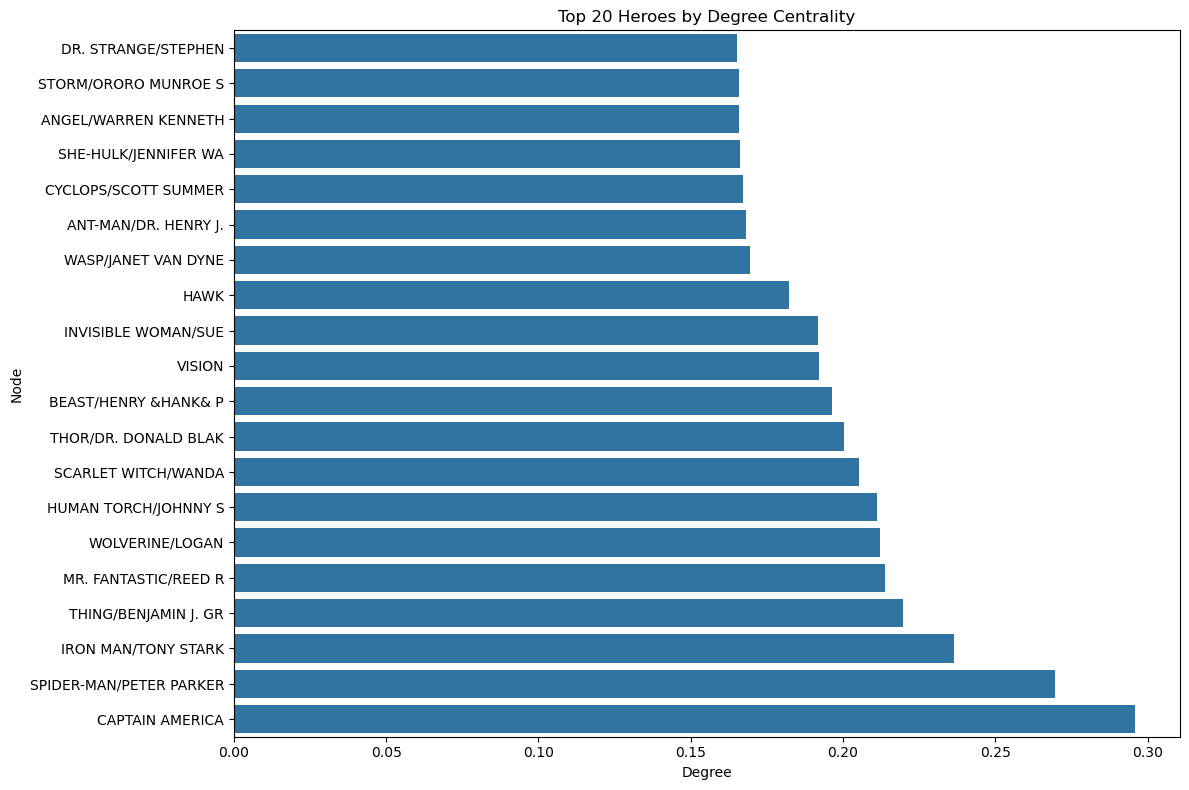

In [58]:
# Compute basic centrality measures for the hero network
def compute_centrality_measures(G):
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, k=100)  # Using k for approximation in large networks
    closeness_centrality = nx.closeness_centrality(G)

    # Create a dataframe with the centrality measures
    centrality_df = pd.DataFrame({
        'Node': list(G.nodes()),
        'Degree': [degree_centrality[node] for node in G.nodes()],
        'Betweenness': [betweenness_centrality[node] for node in G.nodes()],
        'Closeness': [closeness_centrality[node] for node in G.nodes()]
    })

    return centrality_df

# Compute centrality measures for the hero network
hero_centrality = compute_centrality_measures(G_hero)

# Sort by degree centrality to find the most central heroes
top_heroes = hero_centrality.sort_values('Degree', ascending=False).head(20)
print("\nTop 20 heroes by degree centrality:")
display(top_heroes)

# Visualize top heroes by degree centrality
plt.figure(figsize=(12, 8))
sns.barplot(x='Degree', y='Node', data=top_heroes.sort_values('Degree'))
plt.title('Top 20 Heroes by Degree Centrality')
plt.tight_layout()
plt.show()

### 4.1.3. Communities detection

### 4.1.4. Network Density

In [66]:
# Network density calculation
density = nx.density(G_hero)

# Count nodes and edges
num_nodes = G_hero.number_of_nodes()
num_edges = G_hero.number_of_edges()

# Maximum possible edges for an undirected graph without self-loops
max_possible_edges = num_nodes * (num_nodes - 1) / 2

print(f"Network Density Analysis for G_hero:")
print(f"Number of nodes (heroes): {num_nodes}")
print(f"Number of edges (connections): {num_edges}")
print(f"Maximum possible edges: {int(max_possible_edges)}")
print(f"Network density: {density:.6f}")
print(f"Percentage of possible connections that exist: {density*100:.2f}%")

# Interpretation guidance
if density < 0.01:
    print("\nThis is a very sparse network - heroes are connected to very few other heroes relative to the possible connections.")
elif density < 0.1:
    print("\nThis is a sparse network - most heroes are not directly connected to each other.")
elif density < 0.3:
    print("\nThis is a moderately connected network.")
else:
    print("\nThis is a densely connected network - heroes have many connections to other heroes.")

Network Density Analysis for G_hero:
Number of nodes (heroes): 6437
Number of edges (connections): 167007
Maximum possible edges: 20714266
Network density: 0.008062
Percentage of possible connections that exist: 0.81%

This is a very sparse network - heroes are connected to very few other heroes relative to the possible connections.


### 4.1.5. Average Path Length

Is the hero network a single connected component? False
Number of connected components: 23
Size of largest connected component: 6400
Percentage of heroes in largest component: 99.43%
Sizes of next 5 largest components: [9, 7, 2, 1, 1]

Analyzing largest connected component with 6400 nodes and 166951 edges
Average shortest path length: 2.6384
Network diameter (longest shortest path): 5
Network radius: 3

Network Structure Analysis:
This is a very compact network with an average of only 2.64 steps between any two heroes.
This suggests a 'small world' property - any hero can reach any other through just a few connections.

Calculating path length distribution (this may take a while for large networks)...
Network is large, sampling 500 nodes for path length distribution...


  0%|          | 0/500 [00:00<?, ?it/s]

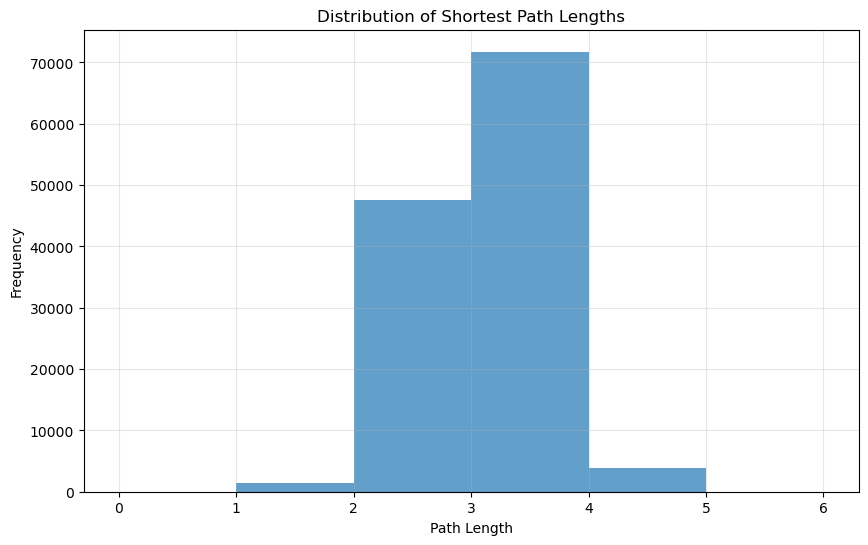


For reference:
- Social networks typically have average path lengths of 3-6
- WWW typically has an average path length of ~19
- Power grids typically have average path lengths of 15-20
- Random networks with same size and density would have path lengths of approximately ln(n)/ln(k)
  where n=6400 and k=average degree ~52.17


In [67]:
# Calculate Average Path Length for G_hero
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# First check if the graph is connected
is_connected = nx.is_connected(G_hero)
print(f"Is the hero network a single connected component? {is_connected}")

# Get the connected components
components = list(nx.connected_components(G_hero))
num_components = len(components)
print(f"Number of connected components: {num_components}")

# Get the sizes of the components
component_sizes = [len(c) for c in components]
largest_component_size = max(component_sizes)
print(f"Size of largest connected component: {largest_component_size}")
print(f"Percentage of heroes in largest component: {largest_component_size / G_hero.number_of_nodes() * 100:.2f}%")

if num_components > 1:
    print(f"Sizes of next 5 largest components: {sorted(component_sizes, reverse=True)[1:6]}")

# Extract the largest connected component for path length analysis
largest_cc = G_hero.subgraph(components[component_sizes.index(largest_component_size)])
print(f"\nAnalyzing largest connected component with {largest_cc.number_of_nodes()} nodes and {largest_cc.number_of_edges()} edges")

# Calculate the average shortest path length for the largest component
try:
    avg_path_length = nx.average_shortest_path_length(largest_cc)
    print(f"Average shortest path length: {avg_path_length:.4f}")
    
    # Calculate the diameter (longest shortest path)
    diameter = nx.diameter(largest_cc)
    print(f"Network diameter (longest shortest path): {diameter}")
    
    # Calculate the radius
    radius = nx.radius(largest_cc)
    print(f"Network radius: {radius}")
    
    # Interpretation of the small world property
    print("\nNetwork Structure Analysis:")
    if avg_path_length < 4:
        print(f"This is a very compact network with an average of only {avg_path_length:.2f} steps between any two heroes.")
        print("This suggests a 'small world' property - any hero can reach any other through just a few connections.")
    elif avg_path_length < 6:
        print(f"This network exhibits the 'small world' property with an average of {avg_path_length:.2f} steps between heroes.")
        print("This is similar to the famous 'six degrees of separation' observed in many real-world networks.")
    else:
        print(f"This network has relatively long paths with an average of {avg_path_length:.2f} steps between heroes.")
        print("Heroes tend to be quite distant from each other in the network structure.")
    
    # Optional: Distribution of path lengths
    print("\nCalculating path length distribution (this may take a while for large networks)...")
    
    # Sample nodes if network is large
    if largest_cc.number_of_nodes() > 1000:
        import random
        sample_size = min(500, largest_cc.number_of_nodes())
        print(f"Network is large, sampling {sample_size} nodes for path length distribution...")
        sample_nodes = random.sample(list(largest_cc.nodes()), sample_size)
        path_lengths = []
        
        for i, source in enumerate(tqdm(sample_nodes)):
            for target in sample_nodes[i+1:]:
                if source != target:
                    try:
                        path_lengths.append(nx.shortest_path_length(largest_cc, source=source, target=target))
                    except:
                        pass
    else:
        # Calculate all path lengths
        path_lengths = []
        for source in tqdm(largest_cc.nodes()):
            paths = nx.single_source_shortest_path_length(largest_cc, source)
            path_lengths.extend(paths.values())
    
    # Create histogram of path lengths
    plt.figure(figsize=(10, 6))
    plt.hist(path_lengths, bins=range(max(path_lengths)+2), alpha=0.7)
    plt.xlabel('Path Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Shortest Path Lengths')
    plt.grid(alpha=0.3)
    plt.show()
    
except nx.NetworkXError as e:
    print(f"Error: {e}")
    print("This usually occurs because the network is not connected.")
    
# Compare with some well-known networks
print("\nFor reference:")
print("- Social networks typically have average path lengths of 3-6")
print("- WWW typically has an average path length of ~19")
print("- Power grids typically have average path lengths of 15-20")
print("- Random networks with same size and density would have path lengths of approximately ln(n)/ln(k)")
print(f"  where n={largest_cc.number_of_nodes()} and k=average degree ~{2*largest_cc.number_of_edges()/largest_cc.number_of_nodes():.2f}")

## 4.2. Hero-comic bipartite network 

In [68]:
# Create a NetworkX graph for the bipartite hero-comic network
G_bipartite = nx.Graph()

# Add all nodes
for _, row in nodes_df.iterrows():
    G_bipartite.add_node(row['node'], type=row['type'])

# Add edges from the hero-comic connections
for _, row in edges_df.iterrows():
    G_bipartite.add_edge(row['hero'], row['comic'])

In [69]:
# Basic network statistics
print("\nBipartite Hero-Comic Network Stats:")
print(f"Number of nodes: {G_bipartite.number_of_nodes()}")
print(f"Number of edges: {G_bipartite.number_of_edges()}")
print(f"Network density: {nx.density(G_bipartite):.6f}")


Bipartite Hero-Comic Network Stats:
Number of nodes: 19091
Number of edges: 96104
Network density: 0.000527


### 4.2.1. Centrality measures


Top 20 comics by degree centrality:


,Node,Degree,Betweenness,Closeness,Eigenvector
2409,COC 1,111,0,0,0
5709,IW 3,91,0,0,0
5707,IW 1,90,0,0,0
4773,H2 279,87,0,0,0
5710,IW 4,80,0,0,0
5708,IW 2,76,0,0,0
6017,MAXSEC 3,72,0,0,0
4056,FF 370,62,0,0,0
6634,M/GN 1,60,0,0,0
5712,IW 6,60,0,0,0


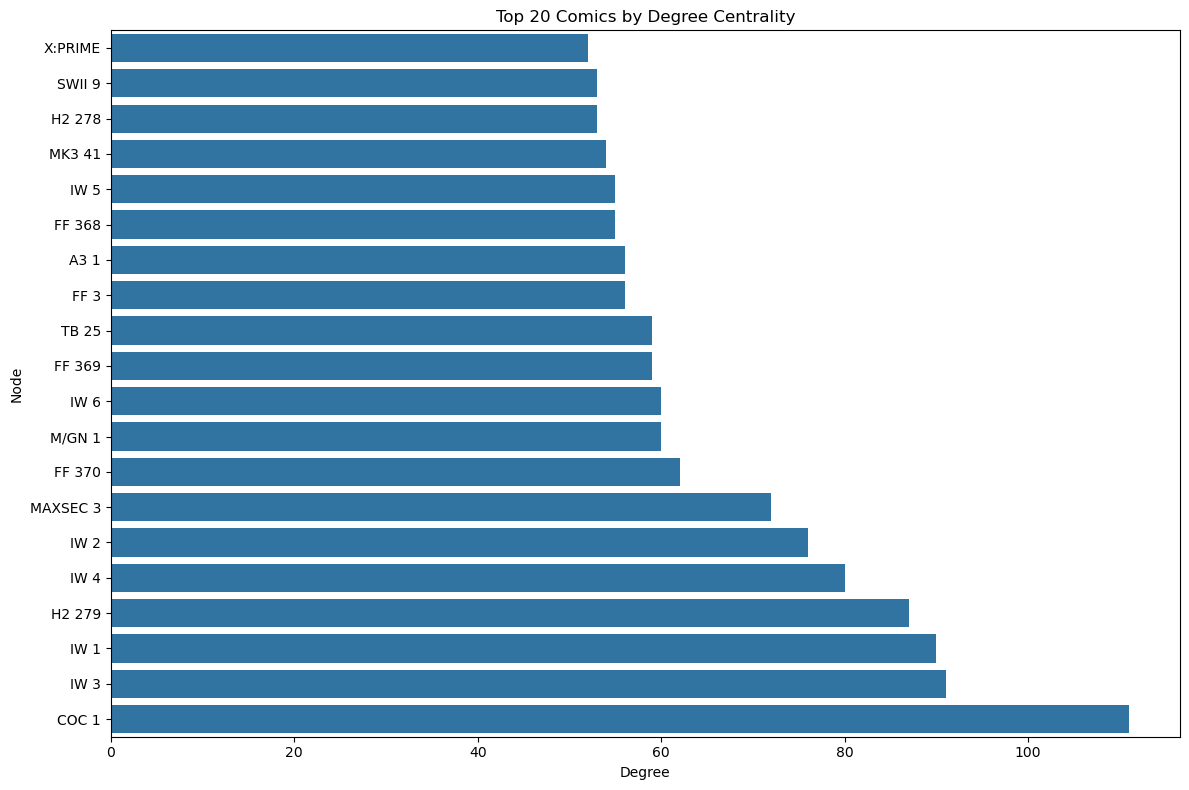

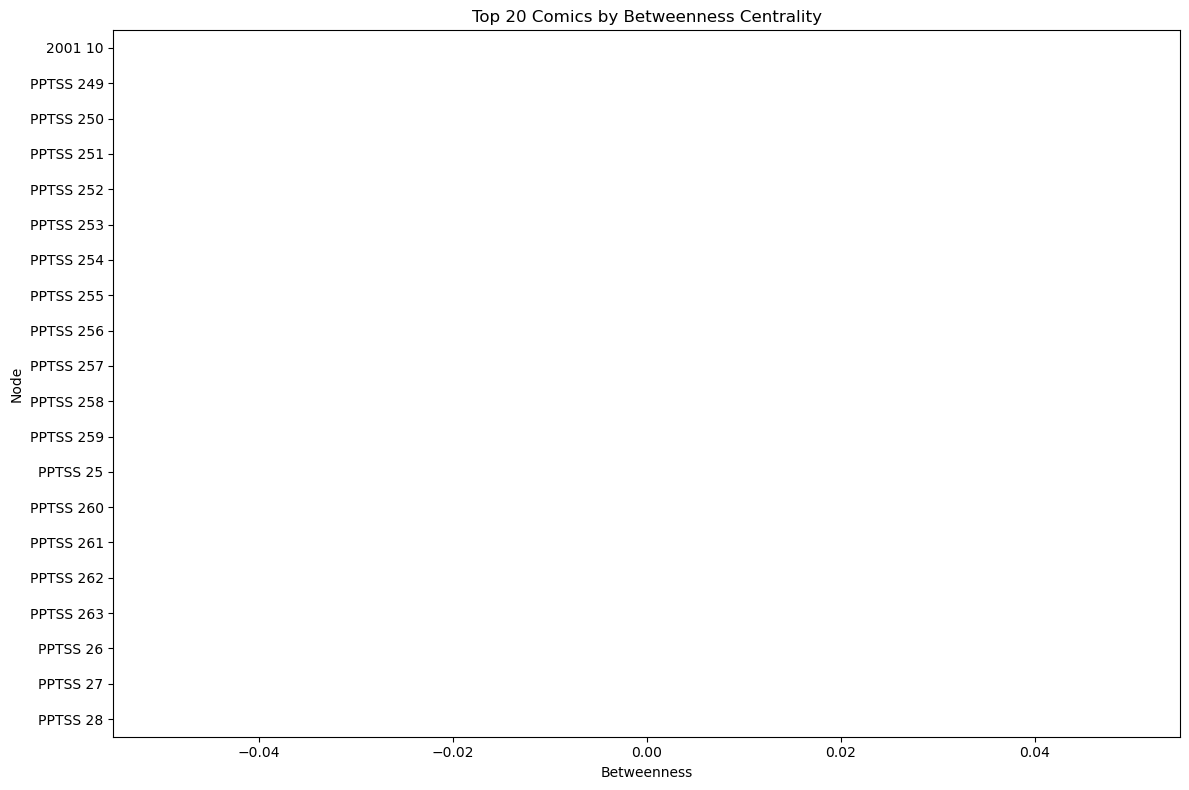

In [70]:
# Function to compute centrality measures for a specific node type in a bipartite graph
def compute_centrality_measures_for_nodetype(G, node_type):
    # Get only the nodes of the specified type
    nodes_of_type = [node for node, attr in G.nodes(data=True) if attr.get('type') == node_type]
    
    # Create a subgraph containing only nodes of the specified type
    # This is needed for some centrality measures
    subgraph = G.subgraph(nodes_of_type)
    
    # Compute centrality measures
    degree_centrality = {node: G.degree(node) for node in nodes_of_type}
    
    # For other centrality measures, we need to be careful with bipartite graphs
    # For betweenness and closeness, we can use the projected graph
    if node_type == 'comic':
        # Create a projected graph where comics are connected if they share a hero
        projected_graph = nx.bipartite.projected_graph(G, nodes_of_type)
    else:
        # Create a projected graph where heroes are connected if they appear in the same comic
        projected_graph = nx.bipartite.projected_graph(G, nodes_of_type)
    
    # Now compute other centrality measures on the projected graph
    try:
        betweenness_centrality = nx.betweenness_centrality(projected_graph)
        closeness_centrality = nx.closeness_centrality(projected_graph)
        eigenvector_centrality = nx.eigenvector_centrality(projected_graph, max_iter=300)
    except:
        # If there's an error (e.g., disconnected graph), use simpler calculation
        betweenness_centrality = {node: 0 for node in nodes_of_type}
        closeness_centrality = {node: 0 for node in nodes_of_type}
        eigenvector_centrality = {node: 0 for node in nodes_of_type}
    
    # Create a DataFrame with the results
    df = pd.DataFrame({
        'Node': nodes_of_type,
        'Degree': [degree_centrality[node] for node in nodes_of_type],
        'Betweenness': [betweenness_centrality.get(node, 0) for node in nodes_of_type],
        'Closeness': [closeness_centrality.get(node, 0) for node in nodes_of_type],
        'Eigenvector': [eigenvector_centrality.get(node, 0) for node in nodes_of_type]
    })
    
    return df

# Compute centrality measures for comics
comic_centrality = compute_centrality_measures_for_nodetype(G_bipartite, 'comic')

# Sort by degree centrality to find the most central comics
top_comics = comic_centrality.sort_values('Degree', ascending=False).head(20)
print("\nTop 20 comics by degree centrality:")
display(top_comics)

# Visualize top comics by degree centrality
plt.figure(figsize=(12, 8))
sns.barplot(x='Degree', y='Node', data=top_comics.sort_values('Degree'))
plt.title('Top 20 Comics by Degree Centrality')
plt.tight_layout()
plt.show()

# You might also want to visualize other centrality measures
# For example, betweenness centrality
top_comics_betweenness = comic_centrality.sort_values('Betweenness', ascending=False).head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x='Betweenness', y='Node', data=top_comics_betweenness)
plt.title('Top 20 Comics by Betweenness Centrality')
plt.tight_layout()
plt.show()